# OpenSCM Timeseries

In OpenSCM, the class for handling timeseries is `openscm.timeseries.Timeseries`. 

A timeseries in OpenSCM is always initialised from arrays i.e. discrete data which are associated with specific points in time. In this notebook we call the initialisation values the 'source data' and the times with which they are associated the 'source times'.

To estimate what the value of the variable under consideration is at points in time other than the source points (call these points the 'target times'), i.e. to interpolate or extrapolate, we always take the following steps:

1. start with the data which was originally used to set the timeseries
1. convert the discrete data to continuous data using an interpolation/extrapolation technique
    - e.g. linear interpolation, cubic spline, moving average
1. use the continuous data to determine the values at the target times aka the 'target values'

There is one additional complication in this process. It is the different conventions that are used with timeseries. For example, sometimes the data value is the value only at the exact point in time for which it is supplied while other times the data value represents the average of the underlying continuous data set over a given time period. These conventions affect how the conversion between continuous and discrete data is done and hence are vital to document and understand.

*Note:* In order to recover the original data from the target data, you need to know which assumptions have been made in the interpolation process and what convention is being used.

In this notebook we go through the different interpolation and extrapolation options available to OpenSCM users as well as the different conventions OpenSCM understands. If your particular use case is not here, please raise an issue at [https://github.com/openclimatedata/openscm/issues]().

In [1]:
from itertools import count
from copy import copy

import numpy as np
from matplotlib import pyplot as plt

from openscm import timeseries
from openscm.core import ParameterSet

<IPython.core.display.Javascript object>

In [2]:
COLOUR_1 = "lime"
COLOUR_2 = "midnightblue"
COLOUR_3 = "firebrick"
COLOUR_4 = "deeppink"

MARKER_1 = "o"
MARKER_2 = "^"
MARKER_3 = "+"
MARKER_4 = "x"

## Holding data

In OpenSCM, all data is stored in instances of `ParameterSet`. 

In [3]:
paras = ParameterSet()

---
## Example 1: Period average data with linear interpolation

As it stands, the only case OpenSCM can handle is linear interpolation of data where the convention is that the source values represent the average of the underlying timeseries over a time period. This time period extends from the time time at which the value is provided, the 'data time', up until the next time in the timeseries. A common example for such a convention is emissions data, where each time point represents the average emissions flux for that time period e.g. 2100 emissions of 3 GtC / yr means that the average rate of emissions for 2100 was 3 GtC / yr.

<div class="alert alert-warning">
  <strong>Warning!</strong> Emissions data is ocassionally reported without the rate e.g. 2100 emissions were 3 GtC. In OpenSCM, we explicitly do not allow this as it doesn't actually make sense. The cumulative emissions for the year were 3 GtC but the emissions were not 3 GtC at any given point in 2100. Before passing emissions data into OpenSCM it should have the units converted to rates (of course, cumulative emissions data should not be reported as rates and so perhaps the only fix required is changing the variable name from `Emissions` to `Cumulative Emissions`).
</div>

### Source data

To start with, we set our source data.

If your data is periodic, all we need to do to specify our timeseries is to provide the start time and period length of the time axis.

In [4]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_period_length = 10
source_view = paras.get_writable_timeseries_view(
    ("Emissions", "CO2"),
    ("World",),
    "GtC / yr",
    start_time=0,
    period_length=source_period_length,
)
source_view.set_series(source_values)

[TODO: make this sane]

The `get_points` method of our view's `_timeseries_converter._source` allows us to get the source times for our data.

In [5]:
source_times = source_view._timeseries_converter._source.get_points(
    len(source_view.get_series())
)
source_times

array([ 0., 10., 20., 30., 40., 50., 60., 70.])

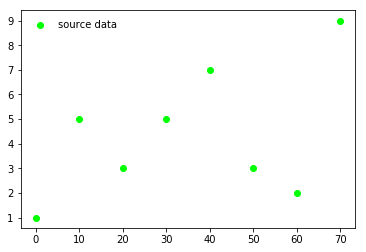

In [6]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source data", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.legend(frameon=False);

### Target data

Next we set our target, using one of OpenSCM's `ParameterView`'s.

In [7]:
target_period_length = 7
target_view = paras.get_timeseries_view(
    ("Emissions", "CO2"),
    ("World",),
    "GtC / yr",
    start_time=-3,
    period_length=target_period_length,
)
target_times = target_view._timeseries_converter._target.get_points(
    len(target_view.get_series())
)

### Conversion

To convert from discrete to continuous data, we interpolate the data such that their average (i.e. integral over the period divided by the period length) equals the original source data. We use three points per period: at each period edge the value is assumed to equal the average of the values for the two adjacent periods and at the period mid point the value is adjusted such that the period average equals the source data value for that period. For the first and the last period the mid points are assumed to be at the period average and the outer edges are adjusted accordingly.

In a picture it looks like the below. To make it easier to see how the interpolation is integral preserving, we plot the source data with lines which show the integral, following the assumption that the data values represent the average over the time period.

In [8]:
def plot_timeframe(ax, values, timeframe, **kwargs):
    ax.step(timeframe.get_points(len(values) + 1), np.concatenate(([values[0]], values)), **kwargs)

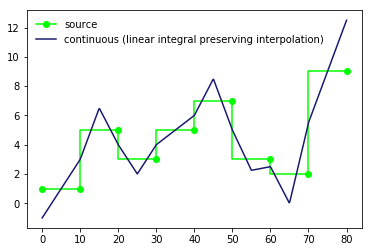

In [9]:
# TODO: make this sane(?)
continuous = timeseries._calc_continuous(
    source_view.get_series(), 
    source_view._timeseries_converter._source
)
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeseries_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    source_times[0], 
    source_times[-1] + source_period_length, 
    500
)
ax.plot(
    plt_times, 
    continuous(plt_times), 
    label="continuous (linear integral preserving interpolation)", 
    marker=None,
    color=COLOUR_2,
)
ax.legend(frameon=False);

In a second step, we calculate the target values by integrating the continuous function. 

*Note:* at the moment extrapolation always occurs [TODO: make this optional].

In [10]:
target_times = target_view._timeseries_converter._target.get_points(
    len(target_view.get_series())
)
interval_times = np.concatenate([
    target_times, 
    [target_times[-1] + target_period_length]
])
interval_averages = timeseries._calc_interval_averages_from_func(
    continuous,
    interval_times
)

In [11]:
interval_averages

array([-0.8       ,  2.02142857,  5.37857143,  3.42857143,  3.34285714,
        5.1       ,  7.18571429,  5.44642857,  2.49642857,  1.20714286,
        5.59285714, 10.75      ])

#### Plot

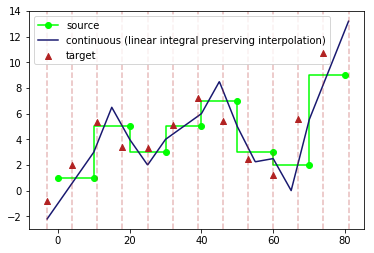

In [12]:
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_view.get_series(), 
    source_view._timeseries_converter._source, 
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    target_times[0], 
    target_times[-1] + target_period_length, 
    500
)
ax.plot(
    plt_times, 
    continuous(plt_times), 
    label="continuous (linear integral preserving interpolation)", 
    marker=None,
    color=COLOUR_2,
)
ax.scatter(
    target_times, 
    interval_averages, 
    color=COLOUR_3, 
    marker=MARKER_2,
    zorder=10, 
    label="target"
)
for x in target_times:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.axvline(x=x + target_period_length, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();

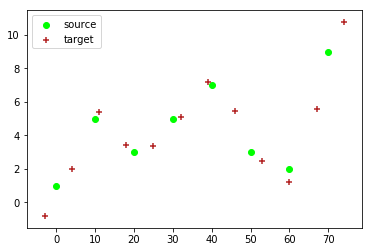

In [13]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    target_times, 
    interval_averages, 
    color=COLOUR_3, 
    marker=MARKER_3,
    label="target"
)
ax.legend();

### Using OpenSCM

Requesting the data from this view includes an automatic conversion onto our new timeseries.

In [14]:
target_view.get_series()

array([-0.8       ,  2.02142857,  5.37857143,  3.42857143,  3.34285714,
        5.1       ,  7.18571429,  5.44642857,  2.49642857,  1.20714286,
        5.59285714, 10.75      ])

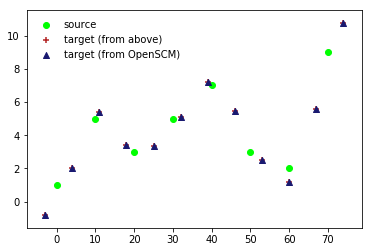

In [15]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times, 
    source_values, 
    label="source", 
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.scatter(
    target_times, 
    interval_averages, 
    color=COLOUR_3, 
    marker=MARKER_3,
    label="target (from above)"
)
ax.scatter(
    target_times, 
    target_view.get_series(), 
    label="target (from OpenSCM)", 
    marker=MARKER_2,
    color=COLOUR_2,
)
ax.legend(frameon=False);

The result is fairly non-intuitive. This is unavoidable as it's much harder to visual the transformations into and out of integral space (which are required to preserve the integrals) than a linear interpolation.